# Vehicle Detection Project

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

In [1]:
%matplotlib inline
from helper_functions import * 

In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog

## Train classification model

In [3]:
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import train_test_split


In [4]:
# Read in cars and notcars
cars = []
notcars = []
for image in glob.iglob('./data/vehicles/**/*.png', recursive=True):
    cars.append(image)
for image in glob.iglob('./data/non-vehicles/**/*.png', recursive=True):
    notcars.append(image)

In [5]:
print("Cars: ", len(cars), "Not Cars: ", len(notcars))

Cars:  8792 Not Cars:  8968


In [6]:
# Reduce the sample size because
# The quiz evaluator times out after 13s of CPU time
# sample_size = 500
# cars = cars[0:sample_size]
# notcars = notcars[0:sample_size]

# feature extraction parameters
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off


/opt/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


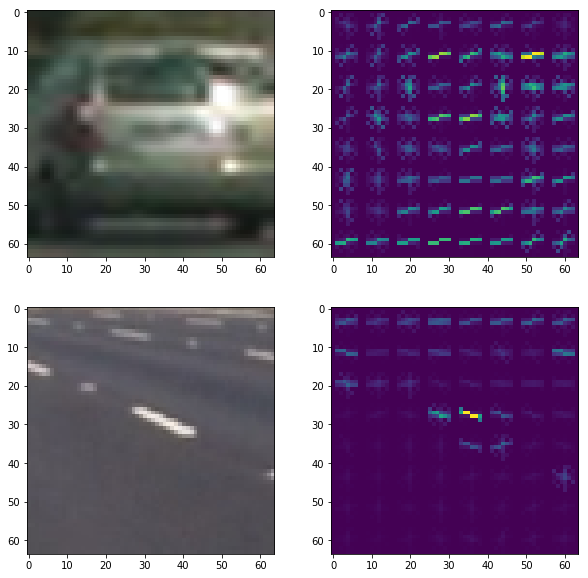

In [7]:
rand_index = np.random.randint(0, 1000)

plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
img = mpimg.imread(cars[rand_index])
plt.imshow(img)
_, hog_image = get_hog_features(img[:,:,0], orient, pix_per_cell, cell_per_block, 
                                       vis=True, feature_vec=True)
plt.subplot(2, 2, 2)
plt.imshow(hog_image)

# plt.figure()
plt.subplot(2, 2, 3)
img = mpimg.imread(notcars[rand_index])
plt.imshow(img)
_, hog_image = get_hog_features(img[:,:,0], orient, pix_per_cell, cell_per_block, 
                                       vis=True, feature_vec=True)
plt.subplot(2, 2, 4)
plt.imshow(hog_image)

In [8]:
%%time
images = cars + notcars
X = extract_features(images, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
X = np.array(X).astype(np.float64)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X[0]))

# Define the labels vector
y = np.hstack((np.ones(len(cars)), np.zeros(len(notcars))))

/opt/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
CPU times: user 1min 27s, sys: 5.46 s, total: 1min 33s
Wall time: 1min 38s


In [9]:
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print("Training set size: ", len(X_train), "Test set size: ", len(X_test))

Training set size:  14208 Test set size:  3552


In [10]:
%%time
# Use a linear SVC 
svc = svm.LinearSVC()
svc.fit(X_train, y_train)
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))


Test Accuracy of SVC =  0.9887
CPU times: user 34.9 s, sys: 2.55 s, total: 37.5 s
Wall time: 38.8 s


Hug Sub-sampling

In [11]:
IMAGE_SHAPE = (720, 1280, 3)

/opt/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


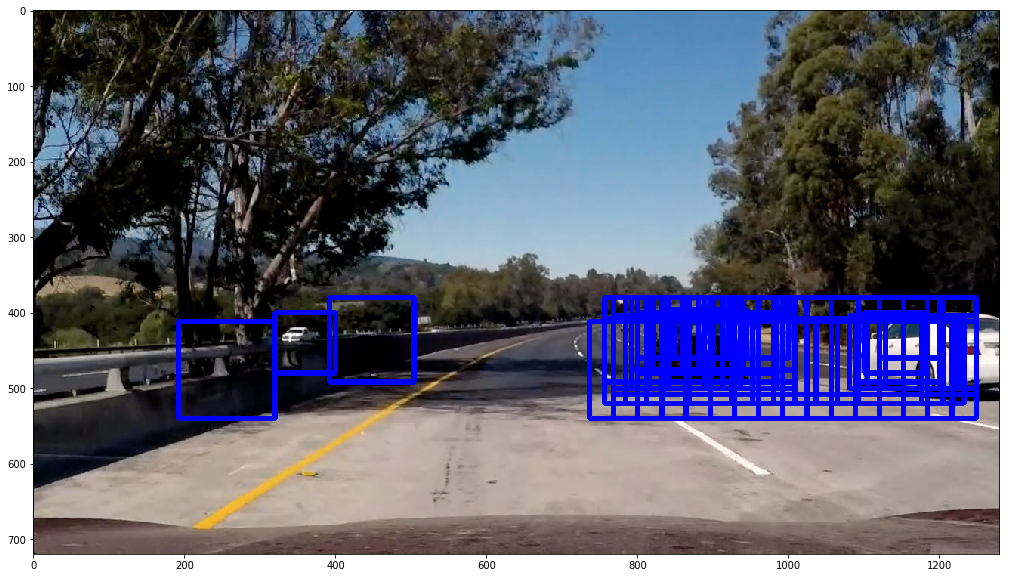

In [12]:
# dist_pickle = pickle.load( open("svc_pickle.p", "rb" ) )
# svc = dist_pickle["svc"]
# X_scaler = dist_pickle["scaler"]
# orient = dist_pickle["orient"]
# pix_per_cell = dist_pickle["pix_per_cell"]
# cell_per_block = dist_pickle["cell_per_block"]
# spatial_size = dist_pickle["spatial_size"]
# hist_bins = dist_pickle["hist_bins"]

test_image = mpimg.imread('./test_images/test5.jpg')

def scale_find_car(image):
    scale_list = [1, 1.25, 1.5, 1.75, 2]
    # xcenter = IMAGE_SHAPE[1]/2
    # xwidth_list = [600, 800, 1000, 1280, 1280]
    # xstart_list = [int(xcenter - w/2) for w in xwidth_list]
    # xstop_list = [int(xcenter + w/2) for w in xwidth_list]
    ystart_list = [380] * 5
    ystop_list = [490, 510, 530, 560, 590]
    # scale = 1

    box_list = []
    out_img = np.copy(image)
    for i in range(len(scale_list)):
        scale = scale_list[i]
    #     xstart = xstart_list[i]
    #     xstop = xstop_list[i]
        ystart = ystart_list[i]
        ystop = ystop_list[i]


        box, out_img = find_cars(out_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        box_list += box
    return box_list, out_img

box_list, out_img = scale_find_car(test_image)
plt.figure(figsize=(20,10))
plt.imshow(out_img)

heat map

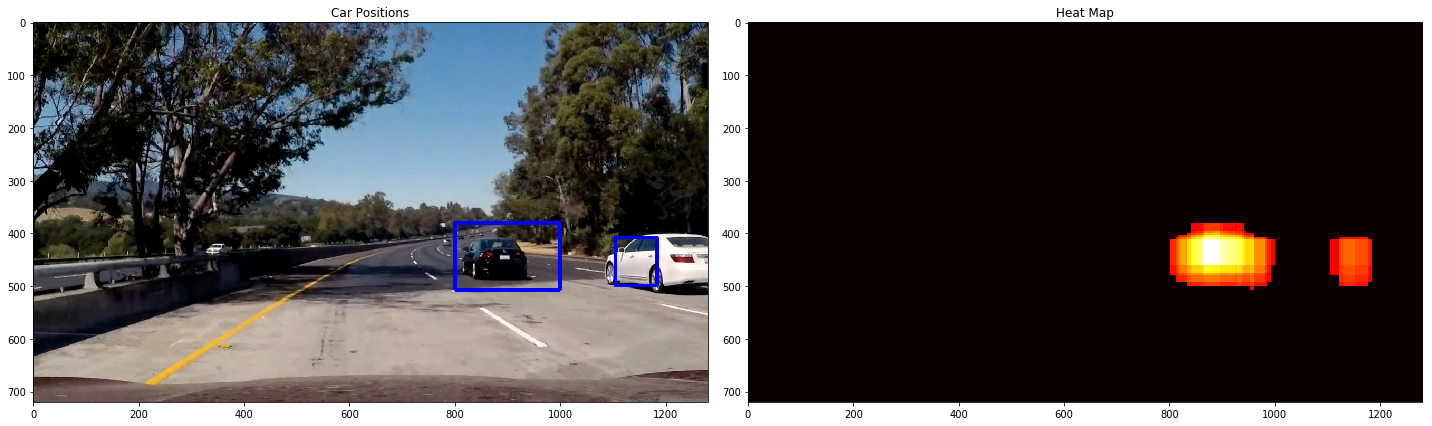

In [13]:
from scipy.ndimage.measurements import label


def heat_lable(image, box_list):
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    def add_heat(heatmap, bbox_list):
        # Iterate through list of bboxes
        for box in bbox_list:
            # Add += 1 for all pixels inside each bbox
            # Assuming each "box" takes the form ((x1, y1), (x2, y2))
            heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

        # Return updated heatmap
        return heatmap# Iterate through list of bboxes

    def apply_threshold(heatmap, threshold):
        # Zero out pixels below the threshold
        heatmap[heatmap <= threshold] = 0
        # Return thresholded map
        return heatmap

    def draw_labeled_bboxes(img, labels):
        # Iterate through all detected cars
        for car_number in range(1, labels[1]+1):
            # Find pixels with each car_number label value
            nonzero = (labels[0] == car_number).nonzero()
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Define a bounding box based on min/max x and y
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            # Draw the box on the image
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        # Return the image
        return img

    # Add heat to each box in box list
    heat = add_heat(heat,box_list)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,10)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    return labels, heatmap, draw_img

labels, heatmap, draw_img = heat_lable(test_image, box_list)
fig = plt.figure(figsize=(20, 10))
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()


## Test on vidoes 

In [14]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [15]:
from collections import deque
prev_box_list = deque(maxlen=5)
def process_image(image):
    box_list, box_image = scale_find_car(image)
    prev_box_list.append(box_list)
    boxes = []
    for b in prev_box_list:
        boxes += b
    labels, heatmap, label_image = heat_lable(image, boxes)
    
    zeros = np.zeros_like(box_image)
    zeros[:, :, 0] = heatmap
    
#     return np.hstack((box_image, zeros, label_image))
    return label_image
    

In [17]:
video_name = "project_video.mp4"
video_output = 'output_' + video_name
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip(video_name)
video_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time video_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video output_project_video.mp4
[MoviePy] Writing video output_project_video.mp4


100%|█████████▉| 1260/1261 [16:23<00:00,  1.28it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_project_video.mp4 

CPU times: user 15min 46s, sys: 47.7 s, total: 16min 34s
Wall time: 16min 24s
